# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [2]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def train_model(model, feature_set, hyperparameters, 
                grid_search = False):
    """Wrapper for training models with optional grid search and feature selection.
    Pass model with no brackets, ie Lars not Lars()
    If grid_search = True, hyperparameters is the hp ranges dictionary. Outputs trained model, best_hp
    If grid_search = False, hyperparameters is the hp dictionary. Outputs trained model"""
    X_train, X_test = X_train_main[feature_set], X_test_main[feature_set]
    
    if grid_search == True:
        best_hp = grid_search_return_hp_dict(model(),
                                             X_train, y_train, hyperparameters)
        print("Grid search complete!\nHyperparameters:\n", best_hp)
        training_model = model(**best_hp).fit(X_train, y_train)
        return training_model, best_hp

    if grid_search == False:
        print("No grid search\nHyperparameters:\n", hyperparameters)
        training_model = model(**hyperparameters).fit(X_train, y_train)
        return training_model

def produce_exp_vs_pred_df(features_list, model, codename): # generalise!
    """Pass features_list as a string"""
    pred_list = []
    for i in range(0, len(dragon_features)):
        prediction = model.predict([dragon_features[eval(features_list)].iloc[i]])
        pred_list.append(prediction)
    
    exp_vs_calc = pd.DataFrame(constants_first)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    exp_vs_calc.to_csv('models/DRAGON_noVPAS/%s'%("expvcalc_" + str(model).split(sep='(')[0] + "_" + features_list[16:] + ".csv"))
    now = datetime.now()

    dt_string = now.strftime("_%d_%m_%Y_%H_%M_%S")
    filename = "models/DRAGON_noVPAS/" + str(model).split(sep='(')[0] + "_" + features_list[16:] + dt_string + ".joblib"
    print(str(model).split(sep='(')[0], "run at:", now, ". Saving to", filename)
    
    joblib.dump(model, filename)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('organics_noVPAS_desc_kh.csv') # contains non-VP/AS HLCs

print("Input Shape", csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print("Removed NaN, new shape", csv.shape) #removed NaN shape

#species_names = csv.pop('Unnamed: 0')
smiles_strings = csv.pop('SMILES')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

X_train_main, X_test_main, y_train, y_test = train_test_split(dragon_features, constants_first, test_size=0.3)

Input Shape (1404, 1479)
Removed NaN, new shape (1355, 1479)


In [4]:
for i in ['X_train_main', 'X_test_main', 'y_train', 'y_test']:
    #joblib.dump(exec('i'), "models/DRAGON_noVPAS/%s.joblib"%i)
    eval('%s'%i).to_csv('models/DRAGON_noVPAS/%s.csv'%i)
    if 'X' in i:
        eval('%s'%i).drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [5]:
fs_model = GradientBoostingRegressor()
fs_model.fit(X_train_main, y_train)
importances = pd.Series(fs_model.feature_importances_, index = X_train_main.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

### Importances via 'dummy' LASSO model

In [6]:
dummy_lasso = Lasso(max_iter=10000, alpha=0.5)
selector = SelectFromModel(dummy_lasso).fit(X_train_main, y_train)
coefs = selector.estimator_.coef_
importances_lasso = pd.Series(coefs, index = X_train_main.columns)
top_15_features_lasso = list(importances_lasso.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [7]:
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X_train_main, y_train)
scores_f = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [8]:
fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X_train_main, y_train)
scores_mutual = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

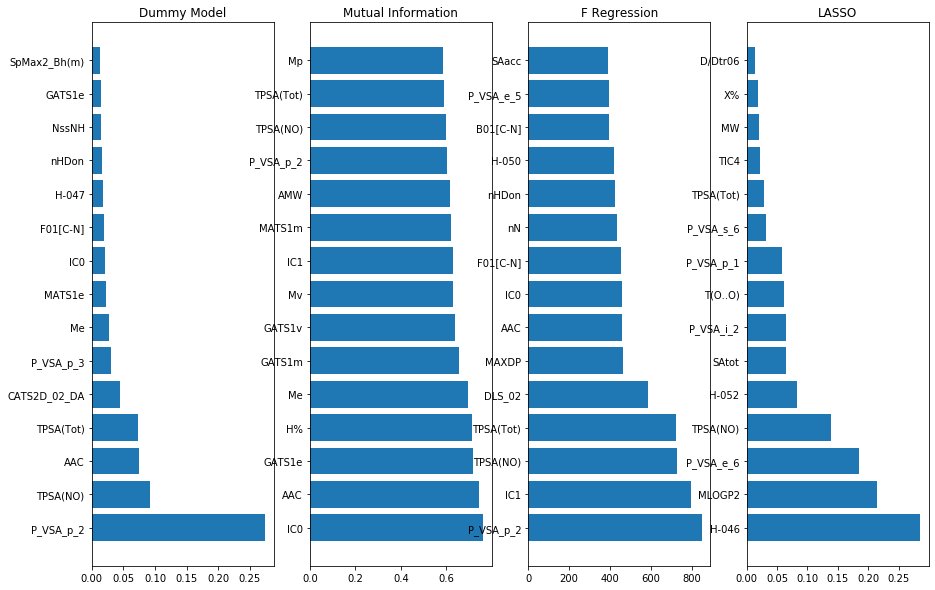

In [9]:
fig, imp_plot = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index.values, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index.values, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index.values, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
imp_plot[3].barh(importances_lasso.nlargest(15).index.values, importances_lasso.nlargest(15))
imp_plot[3].set_title('LASSO')
plt.show()

## Exporting feature importances

In [10]:
joblib.dump(importances, "models/DRAGON_noVPAS/model_importances.joblib")
joblib.dump(importances_lasso, "models/DRAGON_noVPAS/lasso_importances.joblib")
joblib.dump(scores_f, "models/DRAGON_noVPAS/freg_importances.joblib")
joblib.dump(scores_mutual, "models/DRAGON_noVPAS/mutual_importances.joblib")

['models/DRAGON_noVPAS/mutual_importances.joblib']

## GradientBoosting
### Model-chosen features

In [11]:
gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
} #hyperparameters for each gbr grid search

In [12]:
gbr_model, gbr_hp = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=gbr_param_grid)

exp_vs_calc_gbr_model = produce_exp_vs_pred_df('top_15_features_model', gbr_model,
                                         "GradBoost, model-chosen features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000}
Grid search complete!
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-23 13:00:04.100789 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_model_23_01_2020_13_00_04.joblib


In [13]:
exp_vs_calc_gbr_model = produce_exp_vs_pred_df('top_15_features_model', gbr_model,
                                              "Gradboost, model features")

GradientBoostingRegressor run at: 2020-01-23 13:00:06.686664 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_model_23_01_2020_13_00_06.joblib


### F-regression features

In [14]:
gbr_freg = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=gbr_hp)

exp_vs_calc_gbr_freg = produce_exp_vs_pred_df('top_15_features_kbest', gbr_freg,
                                                    "GradBoost, f_reg features")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-23 13:00:12.712633 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_kbest_23_01_2020_13_00_12.joblib


### Mutual info features

In [15]:
gbr_mu = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=gbr_hp)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', gbr_mu,
                                            "GradBoost, Mutual Info")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-23 13:00:18.603308 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_mutual_info_23_01_2020_13_00_18.joblib


### LASSO features

In [16]:
gbr_lasso = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=gbr_hp)
exp_vs_calc_gbr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', gbr_lasso,
                                               "LASSO-features, GBR model")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-23 13:00:24.358619 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_lasso_23_01_2020_13_00_24.joblib


## Decision Tree
### Model-Chosen Features

In [17]:
dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
} #hyperparameters for dtr gridsearch

In [18]:
dtr_model, dtr_hp = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=dtr_param_grid)


exp_vs_calc_dtr_model = produce_exp_vs_pred_df('top_15_features_model', dtr_model,
                                         "Decision Tree, model-chosen features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Grid search complete!
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-23 13:03:02.346536 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_model_23_01_2020_13_03_02.joblib


### F-regression features

In [19]:
dtr_freg = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=dtr_hp)
exp_vs_calc_dtr_freg = produce_exp_vs_pred_df('top_15_features_kbest', dtr_freg,
                                         "Decision Tree, freg features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-23 13:03:04.621589 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_kbest_23_01_2020_13_03_04.joblib


### Mutual info features

In [20]:
dtr_mu = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=dtr_hp)
exp_vs_calc_dtr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', dtr_mu,
                                         "Decision Tree, mutual info features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-23 13:03:06.354523 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_mutual_info_23_01_2020_13_03_06.joblib


### LASSO features

In [21]:
dtr_lasso = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=dtr_hp)

exp_vs_calc_dtr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', dtr_lasso,
                                         "Decision Tree, lasso features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-23 13:03:07.882591 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_lasso_23_01_2020_13_03_07.joblib


## AdaBoost Regressor
### Model Chosen Features

In [22]:
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3),
              GradientBoostingRegressor(),
              DecisionTreeRegressor(),
              Lars(),
              ElasticNet()]

ada_param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
} #hyperparameters for adaboost gridsearch

In [23]:
ada_model, ada_hp = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=ada_param_grid)

exp_vs_calc_ada_model = produce_exp_vs_pred_df('top_15_features_model', ada_model,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
Grid search complete!
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbos

### F-regression features

In [24]:
ada_freg = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_freg = produce_exp_vs_pred_df('top_15_features_kbest', ada_freg,
                                               "AdaBoost, freg features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-23 13:10:42.381717 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_kbest_23_01_2020_13_10_42.joblib


### Mutual info features

In [25]:
ada_mu = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', ada_mu,
                                               "AdaBoost, mutual info features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-23 13:11:58.615799 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_mutual_info_23_01_2020_13_11_58.joblib


### LASSO features

In [26]:
ada_lasso = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_lasso = produce_exp_vs_pred_df('top_15_features_lasso', ada_lasso,
                                               "AdaBoost, model features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-23 13:13:36.118190 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_lasso_23_01_2020_13_13_36.joblib


## LASSO
### Model Chosen Features

In [27]:
lasso_param_grid = {
    'alpha':[0.2, 0.4, 0.6, 0.8],
    'max_iter':[1000, 5000, 10000, 50000],
    'selection':['cyclic', 'random']
}

In [28]:
lasso_model, lasso_hp = train_model(model = Lasso,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=lasso_param_grid)


exp_vs_calc_lasso_model = produce_exp_vs_pred_df('top_15_features_model', lasso_model,
                                                 "LASSO, model features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 10000, 'selection': 'random'}
Grid search complete!
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 10000, 'selection': 'random'}
Lasso run at: 2020-01-23 13:13:43.795617 . Saving to models/DRAGON_noVPAS/Lasso_model_23_01_2020_13_13_43.joblib


### F-regression features

In [29]:
lasso_freg = train_model(model = Lasso,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_freg = produce_exp_vs_pred_df('top_15_features_kbest', lasso_freg,
                                                 "LASSO, f-reg features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 10000, 'selection': 'random'}
Lasso run at: 2020-01-23 13:13:46.058636 . Saving to models/DRAGON_noVPAS/Lasso_kbest_23_01_2020_13_13_46.joblib


### Mutual info features

In [30]:
lasso_mu = train_model(model = Lasso,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lasso_mu,
                                                 "LASSO, mutual info features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 10000, 'selection': 'random'}
Lasso run at: 2020-01-23 13:13:48.382821 . Saving to models/DRAGON_noVPAS/Lasso_mutual_info_23_01_2020_13_13_48.joblib


### LASSO Features

In [31]:
lasso_lasso = train_model(model = Lasso,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lasso_lasso,
                                                 "LASSO, lasso features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 10000, 'selection': 'random'}
Lasso run at: 2020-01-23 13:13:50.963685 . Saving to models/DRAGON_noVPAS/Lasso_lasso_23_01_2020_13_13_50.joblib


## Random Forest Regressor
### Model Chosen Features

In [32]:
random_forest_param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

In [33]:
random_forest_model, rfr_hp = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=random_forest_param_grid)
exp_vs_calc_random_forest_model = produce_exp_vs_pred_df('top_15_features_model', random_forest_model,
                                                         "RandomForest, model features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Grid search complete!
Hyperparameters:
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestRegressor run at: 2020-01-23 14:51:57.317264 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_model_23_01_2020_14_51_57.joblib


### F-regression features

In [34]:
random_forest_freg = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_freg = produce_exp_vs_pred_df('top_15_features_kbest', random_forest_freg,
                                                         "RandomForest, freg features")

No grid search
Hyperparameters:
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestRegressor run at: 2020-01-23 14:52:17.353619 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_kbest_23_01_2020_14_52_17.joblib


### Mutual info features

In [35]:
random_forest_mu = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', random_forest_mu,
                                                         "RandomForest, mutual info features")

No grid search
Hyperparameters:
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestRegressor run at: 2020-01-23 14:52:38.345342 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_mutual_info_23_01_2020_14_52_38.joblib


### LASSO features

In [36]:
random_forest_lasso = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_lasso = produce_exp_vs_pred_df('top_15_features_lasso', random_forest_lasso,
                                                         "RandomForest, lasso features")

No grid search
Hyperparameters:
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestRegressor run at: 2020-01-23 14:52:58.403439 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_lasso_23_01_2020_14_52_58.joblib


## LARS - Least angle regression
### Model chosen features

In [37]:
lars_param_grid = {'n_nonzero_coefs': [0, 5, 10, 15]}

In [38]:
lars_model, lars_hp = train_model(model = Lars,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters= lars_param_grid)
exp_vs_calc_lars_model = produce_exp_vs_pred_df('top_15_features_model', lars_model, "LARS model features")

Lars grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.143e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.143e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce 

{'n_nonzero_coefs': 10}
Grid search complete!
Hyperparameters:
 {'n_nonzero_coefs': 10}
Lars run at: 2020-01-23 14:53:12.838246 . Saving to models/DRAGON_noVPAS/Lars_model_23_01_2020_14_53_12.joblib


### F-regression features

In [39]:
lars_freg = train_model(model = Lars,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters= lars_hp)
exp_vs_calc_lars_freg = produce_exp_vs_pred_df('top_15_features_kbest', lars_freg, "LARS freg features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 10}


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.905e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


Lars run at: 2020-01-23 14:53:14.455897 . Saving to models/DRAGON_noVPAS/Lars_kbest_23_01_2020_14_53_14.joblib


### Mutual info features

In [40]:
lars_mu = train_model(model = Lars,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters= lars_hp)

exp_vs_calc_lars_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lars_mu, "LARS mutual info features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 10}
Lars run at: 2020-01-23 14:53:16.186513 . Saving to models/DRAGON_noVPAS/Lars_mutual_info_23_01_2020_14_53_16.joblib


### LASSO features

In [41]:
lars_lasso = train_model(model = Lars,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters= lars_hp)
exp_vs_calc_lars_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lars_lasso, "LARS lasso features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 10}
Lars run at: 2020-01-23 14:53:17.945212 . Saving to models/DRAGON_noVPAS/Lars_lasso_23_01_2020_14_53_17.joblib


## Elastic Net (linear regression l1 l2 norm regularization)
### Model chosen features

In [42]:
net_param_grid = {
    'alpha':[0.1, 0.3, 0.5, 0.8, 1.0],
    'l1_ratio':[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'fit_intercept':[True, False],
    'max_iter': [1000, 3000, 5000],
    'tol':[0.0001, 0.001, 0.01],
    'selection':['cyclic', 'random']
}

In [43]:
net_model, net_hp = train_model(model = ElasticNet,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters= net_param_grid)
exp_vs_calc_net_model = produce_exp_vs_pred_df('top_15_features_model', net_model, "ElasticNet model features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
Grid search complete!
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
ElasticNet run at: 2020-01-23 14:53:41.408913 . Saving to models/DRAGON_noVPAS/ElasticNet_model_23_01_2020_14_53_41.joblib


### F regression features

In [44]:
net_freg = train_model(model = ElasticNet,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_freg = produce_exp_vs_pred_df('top_15_features_kbest', net_freg, "ElasticNet freg features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
ElasticNet run at: 2020-01-23 14:53:43.214220 . Saving to models/DRAGON_noVPAS/ElasticNet_kbest_23_01_2020_14_53_43.joblib


### Mutual info features

In [45]:
net_mu = train_model(model = ElasticNet,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', net_mu, "ElasticNet mutual info features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
ElasticNet run at: 2020-01-23 14:53:44.939507 . Saving to models/DRAGON_noVPAS/ElasticNet_mutual_info_23_01_2020_14_53_44.joblib


### LASSO features

In [46]:
net_lasso = train_model(model = ElasticNet,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_lasso = produce_exp_vs_pred_df('top_15_features_lasso', net_lasso, "ElasticNet lasso features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1694.4525810404884, tolerance: 401.20752102064785
  positive)


ElasticNet run at: 2020-01-23 14:53:46.639029 . Saving to models/DRAGON_noVPAS/ElasticNet_lasso_23_01_2020_14_53_46.joblib
